# Using Machine Learning to Predict Fitbit Sleep Scores

In this project I'm going to apply various Machine Learning models to predict Fitbit Sleep Scores based on a sample of almost one year of sleep score data. I will compare the accuracies of teh different models and look into the feature importances in each of the models.

## Import the relevant libraries and data

In [165]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [178]:
# Import the data
sleep = pd.read_csv('combined.csv')

## Reorganise some columns

In [179]:
sleep.head()

,Unnamed: 0,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [180]:
# Drop the first two columns
sleep_stats = sleep[sleep.columns[2:]]
sleep_stats

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,478,85,31,563,95,293,90,78.0,19.0,20.0,39.0,90.0,54.0,0.094812
282,423,51,28,474,89,263,71,85.0,20.0,22.0,43.0,71.0,52.0,0.055249
283,540,85,30,625,114,324,102,86.0,20.0,23.0,43.0,102.0,52.0,0.060751
284,525,64,31,589,93,322,110,88.0,19.0,24.0,45.0,109.0,53.0,0.060221


The amount of deep sleep (measured in minutes) appears twice in the DataFrame and seems to slightly vary, which could be due to rounding. I will drop the first occurence and rename the second.

In [181]:
# Drop first deep sleep column and rename the second
sleep_data = sleep_stats.drop(columns='Minutes Deep Sleep')

In [183]:
# Rename what used to be the second deep sleep column
sleep_data.rename(columns={'deep_sleep_in_minutes': 'Minutes Deep Sleep'},inplace=True)
sleep_data

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,overall_score,composition_score,revitalization_score,duration_score,Minutes Deep Sleep,resting_heart_rate,restlessness
0,456,42,37,498,94,271,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,412,88,32,500,79,208,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,412,61,26,473,91,242,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,342,59,26,401,71,196,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,530,108,39,638,98,305,82.0,20.0,20.0,42.0,126.0,62.0,0.097103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,478,85,31,563,95,293,78.0,19.0,20.0,39.0,90.0,54.0,0.094812
282,423,51,28,474,89,263,85.0,20.0,22.0,43.0,71.0,52.0,0.055249
283,540,85,30,625,114,324,86.0,20.0,23.0,43.0,102.0,52.0,0.060751
284,525,64,31,589,93,322,88.0,19.0,24.0,45.0,109.0,53.0,0.060221


This table includes a couple of variables hat the Fitbit App does not provide to its users. These "secret" variables are composition score, revitalization score, duration score and restlessness. All other variables, including resting heart rate are easily accessible through the App. It does not take a rocket scientist to see that the overall sleep score is a sum of those three sub scores. Perfectly deconstructing the Fitbit sleep score therefore comes down to understanding how Fitbit computes these "secret" subscores, the rest is simple addition.

## First intuitions about the "secret" subscores

Because the lifetime export from Fitbit provided the 7 right-most variables included in the DataFrame I'm going to assume that the information provided that is not the overall sleep score or any of the three subscores is highly relevant to the computation of the subscores.

As a first step I am just going to look at the names of the 3 "secret" subscores and think about what other variables in the DataFrame could be relevant in computing those.

Composition score sounds like what it could be measuring is the composition of the overall time in bed, i.e. how much of it is spent awake and in each sleep stage.

The "duration" in duration score indicates that this score is a measure of how long you are either in bed or asleep.

Revitalisation score could be a bit more tricky but the name suggests that it is a measure of how restorative the sleep is and factors such as resting heart rate and restlessness could play an important role here.

All these are just educated guesses but build a good foundation for any statistical or mathematical analysis that follows.

## Visualising relationships

To get a visual understanding of which veriables could be related to which score I will create scatter plots of each possible independent variable and each score as a dependent variable.

In [184]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

In [207]:
# Store deep sleep column in variable
last_three = sleep_data[sleep_data.columns[-3:]]

# Obtain the "core" DataFrame with all possible independent variables
core_df = sleep_data[sleep_data.columns[:6]].join(last_three)

Now, I am going to create a DataFrame that has each of the "secret" scores as the last column and therefore the dependent variable. I will then use these DataFrames to visualise the relationships.

In [198]:
# Store the secret scores in variables
composition = sleep_data['composition_score']
revitalization = sleep_data['revitalization_score']
duration = sleep_data['duration_score']

In [203]:
# Create DataFrames to be used for visualising the relationships
composition_df = core_df.join(composition)
revitalization_df = core_df.join(revitalization)
duration_df = core_df.join(duration)

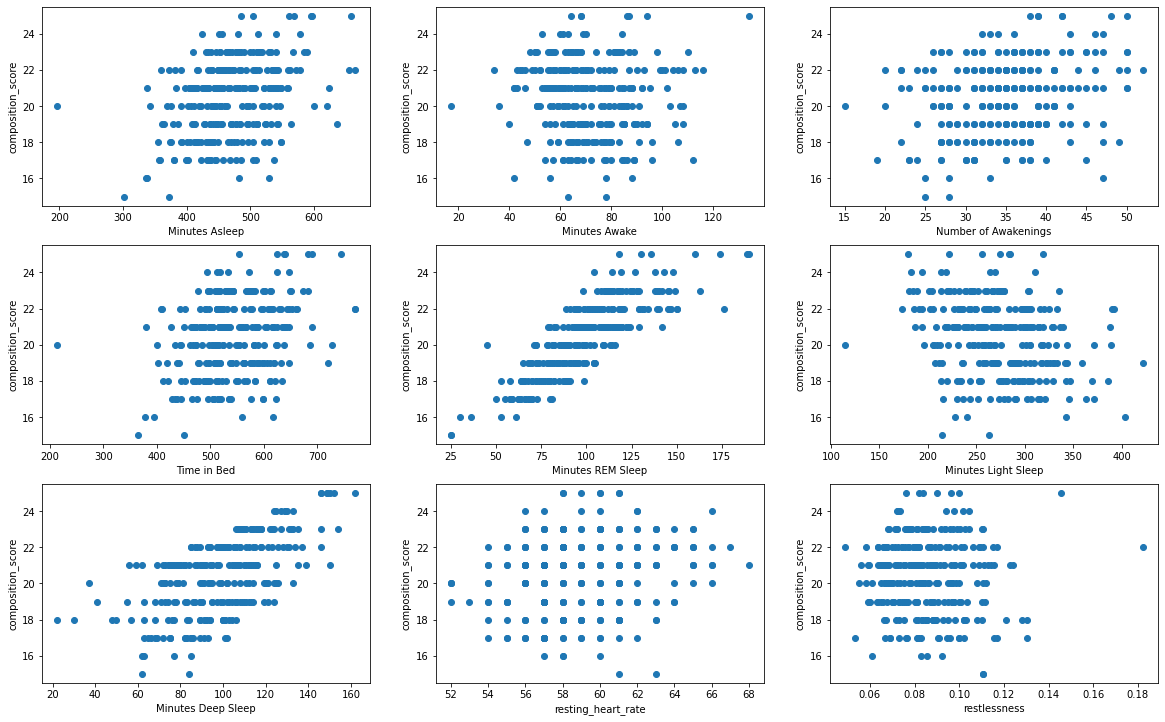

In [200]:
# Plot teh relationships with the composition score
plot_relationships(composition_df, 3)

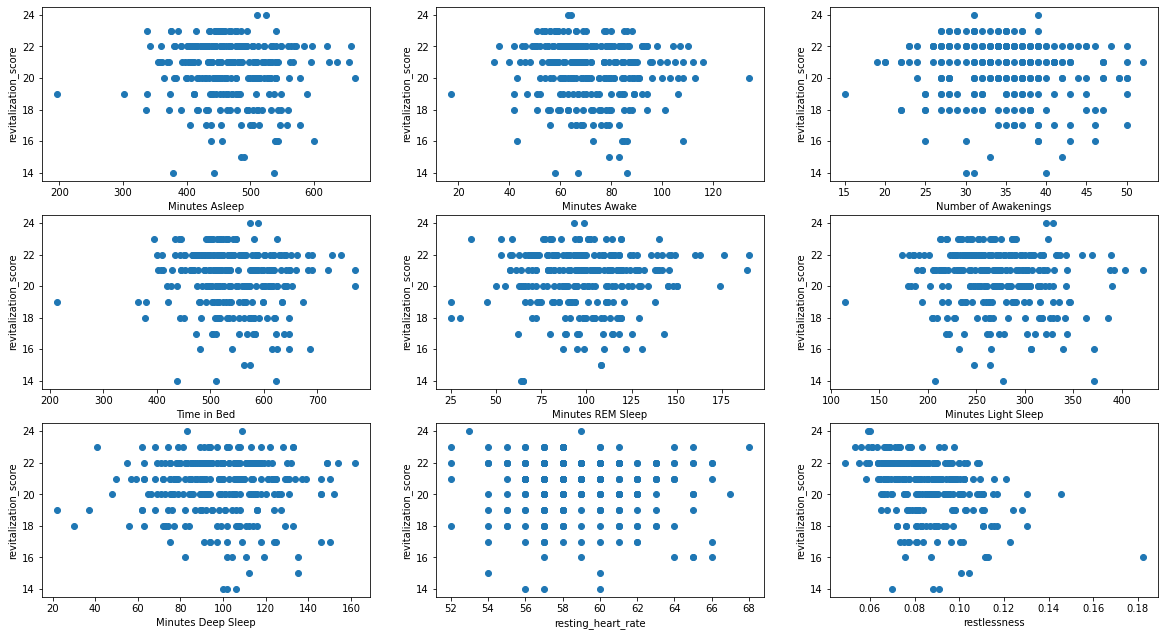

In [201]:
# Plot teh relationships with the revitalization score
plot_relationships(revitalization_df, 3)

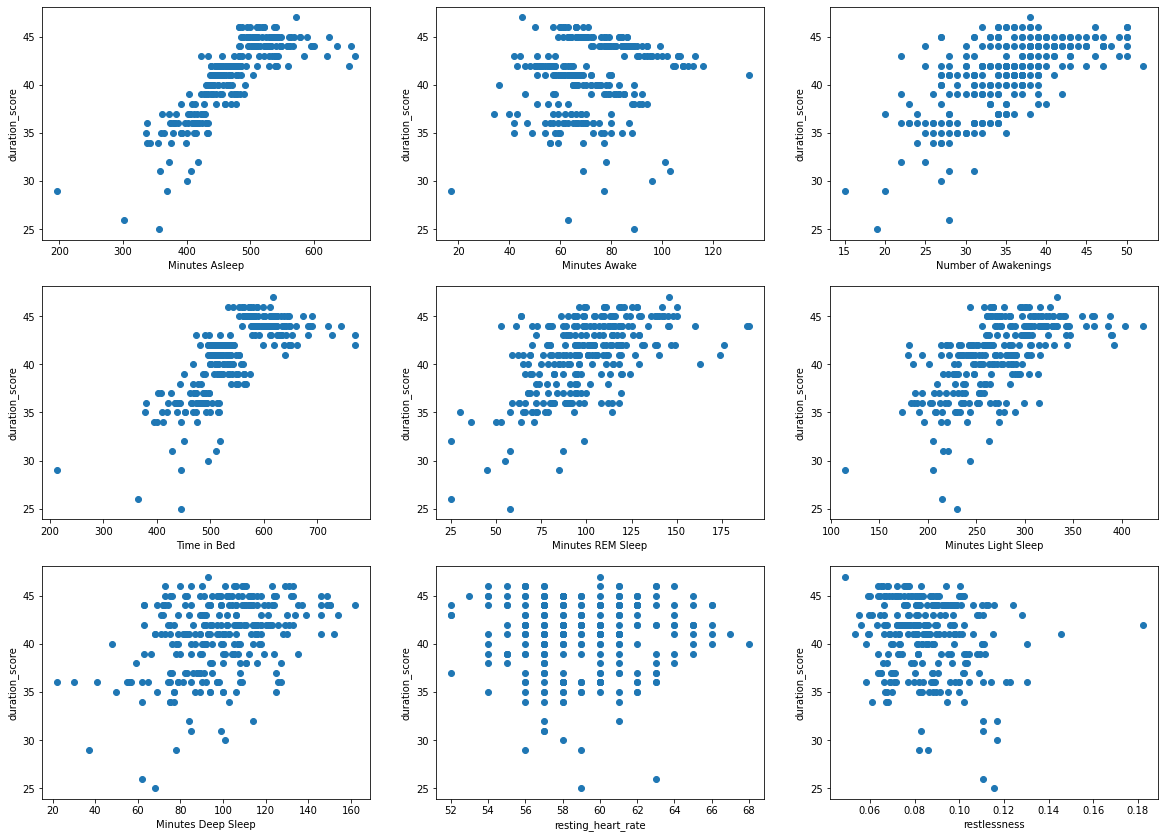

In [204]:
# Plot teh relationships with the duration score
plot_relationships(duration_df, 3)

Finally, let's have a look at the overall correlation matrix

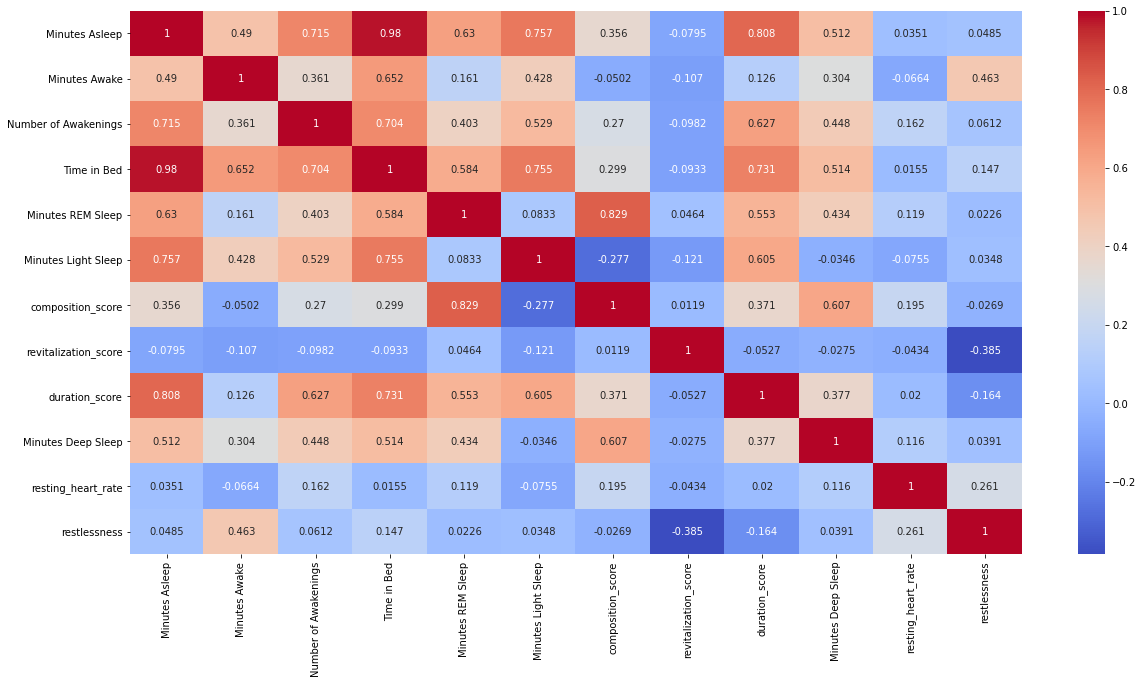

In [209]:
# Inspect the correlations
plt.figure(figsize=(20, 10))
sns.heatmap(sleep_data.drop(columns='overall_score').corr(), annot=True, cmap='coolwarm', fmt='.3g')

## Visualise the relationships between features and sleep score

Before moving on to the analysis and building of Machine Learning models I want to have a look at the relationship that each individual feature has with the overall sleep score to get a sense of their impact on it.

In [141]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,60))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1